***
# Speed Dating Partner Prediction

Authors: Erinn Shu Han Lee, Lukáš Mikšovský

## Introduction
For our Python project, we have chosen [this dataset](https://www.kaggle.com/datasets/ulrikthygepedersen/speed-dating?resource=download) from the Kaggle website. It includes data from an experimental speed dating project that between 2002 and 2004.

Our goal is to predict whether two individuals on a speed date will match at the end of the round of speed dating.
***

## Preliminary Data Analysis

In [297]:
# Import preliminary modules
import pandas as pd

import seaborn as sns
import numpy as np
from scipy.stats import norm, stats

import warnings
warnings.filterwarnings('ignore')
random_seed = 123

# For reproducibility
np.random.seed(random_seed)

In [298]:
# Load data
df = pd.read_csv("speeddating.csv")
print('Dataset size: ', df.shape)
df.info()

Dataset size:  (8378, 123)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(59), object(64)
memory usage: 7.9+ MB


There are 122 independent variables in the dataset.

Slightly less than half (59 columns are float64) are numeric data and the rest (64 columns are object(string)) are categorical data.

The numeric data consists of each participants' rating of their date for the following qualitative attributes:
1. Attractiveness
2. Sincerity
3. Intelligence
4. Fun
6. Ambition
6. Shared Interests (e.g., sports, museums, clubbing, etc.)

The categorical data gathered from the participants through a questionnaire to understand their background better are as follows:
1. Demographics
2. Dating habits
3. Self-perception across key attributes
4. Beliefs on what others find valuable in a mate
5. Lifestyle information

The raw data for both numeric and categorical data can be seen in the following table:

In [299]:
# Check data statistics
df.describe()

,wave,age,age_o,d_age,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,...,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met
count,8378.000000,8283.000000,8274.000000,8378.000000,8299.000000,8299.000000,8289.000000,8289.000000,8289.000000,8280.000000,...,8299.000000,8299.000000,8299.000000,8220.000000,8277.000000,1800.000000,7205.000000,8138.000000,8069.000000,8003.000000
mean,11.350919,26.358928,26.364999,4.185605,3.784793,3.651645,22.495347,17.396867,20.270759,17.459714,...,7.851066,5.631281,4.339197,0.196010,5.534131,5.570556,3.207814,6.134087,5.207523,0.049856
std,5.995903,3.566763,3.563648,4.596171,2.845708,2.805237,12.569802,7.044003,6.782895,6.085526,...,1.791827,2.608913,2.717612,0.303539,1.734059,4.762569,2.444813,1.841285,2.129565,0.282168
min,1.000000,18.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,-0.830000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,24.000000,24.000000,1.000000,1.000000,1.000000,15.000000,15.000000,17.390000,15.000000,...,7.000000,4.000000,2.000000,-0.020000,5.000000,2.000000,2.000000,5.000000,4.000000,0.000000
50%,11.000000,26.000000,26.000000,3.000000,3.000000,3.000000,20.000000,18.370000,20.000000,18.000000,...,8.000000,6.000000,4.000000,0.210000,6.000000,4.000000,3.000000,6.000000,5.000000,0.000000
75%,15.000000,28.000000,28.000000,5.000000,6.000000,6.000000,25.000000,20.000000,23.810000,20.000000,...,9.000000,8.000000,7.000000,0.430000,7.000000,8.000000,4.000000,7.000000,7.000000,0.000000
max,21.000000,55.000000,55.000000,37.000000,10.000000,10.000000,100.000000,60.000000,50.000000,50.000000,...,10.000000,10.000000,10.000000,0.910000,10.000000,20.000000,18.000000,10.000000,10.000000,8.000000


Next, we plotted a bar chart to show how each category contributes to the dataset as a whole. It also helps us identify trends and patterns in the data in a simple way.

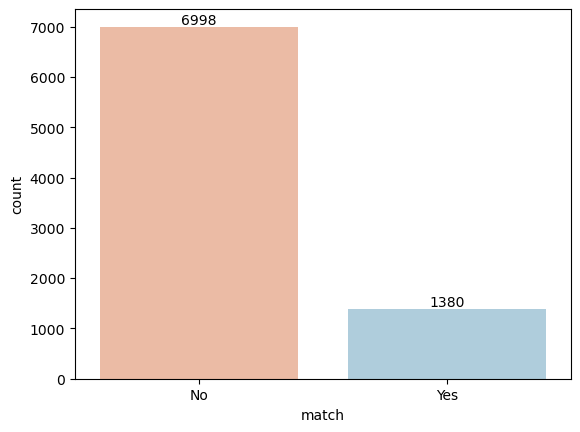

In [300]:
import matplotlib.pyplot as plt

plt.figure()
ax = sns.countplot(x='match', data=df, palette='RdBu')

for i in ax.containers:
    ax.bar_label(i,)

plt.xticks([0,1], ['No', 'Yes'])

plt.show()

However, as seen in the plot, most of the dates were unfortunately not matches. For instance, the short date was not a success 6998 times. Matches between two participants only occurred 1380 times.

This means that our dataset is skewed towards the target of 0="no". We have to keep this in mind when we evaluate the confusion matrix in the later section.

## Data Preprocessing

Now, we will focus on cleaning the data to get the data ready for machine learning analysis. It will help to improve the accuracy and quality of these models and reduce dimensionality.

First, it is important to ensure that our dataset is complete.

In [301]:
print(df.isnull().sum())

has_null                0
wave                    0
gender                  0
age                    95
age_o                 104
                     ... 
d_guess_prob_liked      0
met                   375
decision                0
decision_o              0
match                   0
Length: 123, dtype: int64


From the above, we identified some missing data. Missing data will lead to biased or skewed interpretations of the data if left as it is. Hence, we will be imputing these missing values to help maintain the consistency and integrity of data for further processing, analysis, and modeling.

In [302]:
for i in df.columns[df.isnull().any(axis=0)]:
    df[i].fillna(df[i].mean(),inplace=True)

# Re-check if there are any missing data after imputing
print(df.isnull().sum())

has_null              0
wave                  0
gender                0
age                   0
age_o                 0
                     ..
d_guess_prob_liked    0
met                   0
decision              0
decision_o            0
match                 0
Length: 123, dtype: int64


Next, to utilize machine learning algorithms and statistical techniques in the later sections, we will first convert the categorical and textual data into numeric data. This will help the algorithm to use the data and extract insights from it. The conversion process will recognize patterns, relationships, and similarities in the data.

For this dataset, we will use ordinal encoder. The encoder will assign a unique integer value to each category based on their order or rank in the hierarchy. It ensures that the order of the data is maintained and enable the algorithm to understand the relative relationships between the different categories.

In [303]:
from sklearn.preprocessing import OrdinalEncoder
for col in df.columns:
    if df[col].dtype == "object":
        oe = OrdinalEncoder()
        oe.fit(df[[col]])
        df[col] = oe.fit_transform(df[[col]])
        
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(123)
memory usage: 7.9 MB


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0.0,1.0,0.0,21.0,27.0,6.0,2.0,1.0,3.0,0.0,...,0.0,1.0,7.0,6.000000,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,0.0,1.0,3.0,0.0,...,0.0,1.0,7.0,5.000000,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,21.0,22.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,7.0,5.207523,1.0,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,1.0,1.0,3.0,0.0,...,0.0,1.0,7.0,6.000000,1.0,1.0,0.0,1.0,1.0,1.0
4,0.0,1.0,0.0,21.0,24.0,3.0,1.0,1.0,4.0,0.0,...,0.0,1.0,6.0,6.000000,1.0,1.0,0.0,1.0,1.0,1.0


## Model Building - Logistic Regression

In [304]:
# Initialize data
X = df.drop(['match'], axis=1)
y = df['match']

In [305]:
# Split dataset into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6702, 122), (6702,), (1676, 122), (1676,))

For our data, we we have decided to utilize logistic regression as the outcome variable is categorical ("yes" or "no") and the input variables contain both numeric and categorical data.

It is important to note that logistic regression assumes a linear relationship between the input variables and the log-odds of the outcome variable. Hence, it is sensitive to outliers and multicollinearity. With the prior data preprocessing and transformiation, we believe this model will be able to best predict the probability of two individuals matching at the end of the round of speed dating.

In [306]:
from sklearn.linear_model import LogisticRegression

# Instantiate classifier
logreg = LogisticRegression()

# Fit logreg into the training data
logreg.fit(X_train, y_train)

# Predict on the test data
y_pred = logreg.predict(X_test)

# Evaluate accuracy of the model
logreg.score(X_test, y_test)

0.9928400954653938

The above accuracy score of 0.96897 (rounded to 5 decimal places) indicates a close to perfect classification accuracy, as 0 indicates complete misclassification and 1 indiccates perfect classification.

## Metaparameter Tuning - Logistic Regression

To systematically search through the range of hyperparameters to find the best combination of values to optimize the logistic regression model performance, we perform GridSearchCV.

GridSearchCV results in higher accuracy on the test set and ensures that the model is not overfitting to the training set and is generalizing well to new, unseen data.

In [307]:
from sklearn.model_selection import GridSearchCV

# Specify the hyperparameter as a dictionary
param_grid = {'C': np.logspace(-4, 4, 5), "penalty": ["l1", "l2"]}

# Create grid search
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Performs the actual grid search inplace
logreg_cv.fit(X_train, y_train)
log_pred = logreg_cv.predict(X_test)

# Returns the hyperparameter that performs the best
print(logreg_cv.best_params_)

# Returns the mean cross-validation score over that fold
print(logreg_cv.best_score_)

{'C': 1.0, 'penalty': 'l2'}
0.9850762963704967


<insert explanation on the results>

## Model Evaluation - Logistic Regression

To evaluate the performance of the logistic regression classifier, we will use a Receiving Operating Characteristic (ROC) curve by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

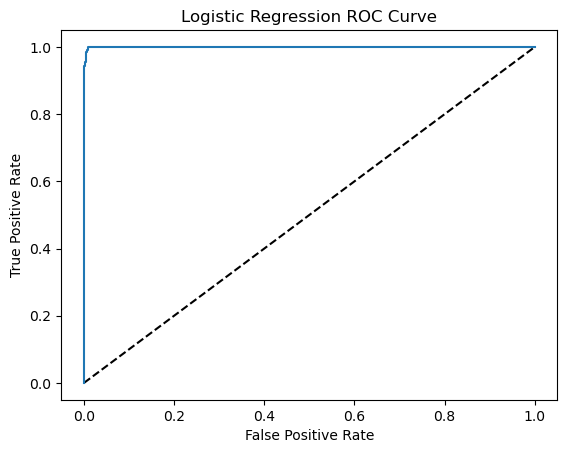

In [308]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities from logreg before using a threshold to predict the label
y_pred_prob = logreg.predict_proba(X_test)[:,1]
            
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

From the above ROC curve, it is noted that the curve is close to the top left corner of the plot, which corresponds to high TPR and low FPR. Hence, we can say that the model is able to distinguish between the positive and negative classes well across all possible threshold values.

To further illustrate this metric, we use the Area under the ROC curve (AUC) to evaluate the model performance.

In [309]:
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute AUC score
print(roc_auc_score(y_test, y_pred_prob))

# Compute cross-validated AUC scores
from sklearn.model_selection import cross_val_score
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print(cv_auc)

0.9997230836013102
[0.99600673 0.99737578 0.99060041 0.99995597 1.        ]


Since the AUC score is close to 1, it indicates a good performance.

## Model Building - Random Forest

For comparison, we will build a Random Forest classification model to contrast it with the Logistic Regression classification model.

Random Forest is a tree-based model where multiple decision trees are trained on random subsets of data and their outputs are combined to make predictions.

In [310]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into features and target variable
X = df.drop('match', axis=1)
y = df['match']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the random forest model with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9940334128878282


<insert explanation on the results>

## Metaparameter Tuning - Random Forest

Similar to the logistic regression classification, we will use GridSearchCv to find the best hyperparameters for the Random Forest Model.

In [311]:
from sklearn.model_selection import GridSearchCV

# Define parameters
parameters = {"max_depth": [5, 10, 15]}

# Create grid search
grid_search = GridSearchCV(rf, parameters, cv=5)
grid_search.fit(X_train, y_train)
tree_pred = grid_search.predict(X_test)
# Get best parameters
grid_search.best_params_

# Get best model
grid_search.best_estimator_

# Get best score
grid_search.best_score_

print(grid_search.best_params_,
      grid_search.best_estimator_,
      grid_search.best_score_)

{'max_depth': 15} RandomForestClassifier(max_depth=15, random_state=42) 0.9940325219539885


<insert explanation on the results>

## Model Evaluation - Random Forest

To evaluate the performance of the Random Forest classifier to be compared to that of the Logistic Regression Classifier, we will also plot the ROC curve at various threshold settings.

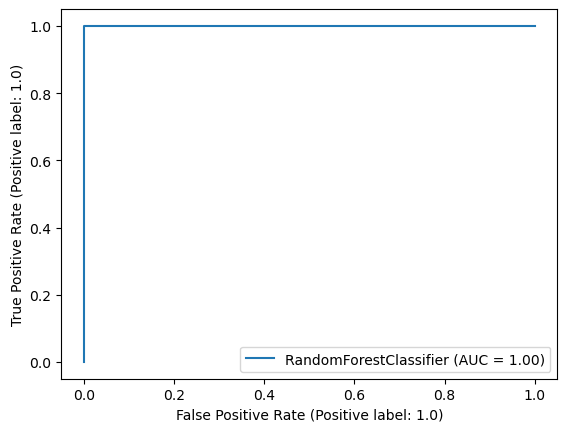

In [312]:
# Get ROC curve
from sklearn.metrics import RocCurveDisplay

# ROC curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(grid_search.best_estimator_, X, y, ax=ax)
plt.show()

<insert explanation on the results>

## Model Comparison

To evaluate the performance of the above two classification models, we will create a confusion matrix for both models to compare the actual values of the target variable with the predicted values in the model. This will quantify the accuracy of a classification model.

Here, the confusion matrix contains four values: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

In [313]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [314]:
# Confusion Matrix for Logistic Regression
print(classification_report(y_test, log_pred))
print(confusion_matrix(y_test, log_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      1389
         1.0       0.15      0.15      0.15       287

    accuracy                           0.71      1676
   macro avg       0.49      0.49      0.49      1676
weighted avg       0.71      0.71      0.71      1676

[[1140  249]
 [ 243   44]]


In [315]:
# Confusion Matrix for Random Forest
print(classification_report(y_test, tree_pred))
print(confusion_matrix(y_test, tree_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1389
         1.0       1.00      0.96      0.98       287

    accuracy                           0.99      1676
   macro avg       1.00      0.98      0.99      1676
weighted avg       0.99      0.99      0.99      1676

[[1389    0]
 [  11  276]]


## Conclusion

In conclusion, ... <insert explanation on the results>

***
# ARCHIVE CODE (to be delated later if not used)

In [316]:
# Decision Tree classifier

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree.score(X_test, y_test)

# Get predictions
random_forest_prediction = grid_search.best_estimator_.predict(X_val)
random_forest_prediction[:10]

# Get report of model
random_forest_report = classification_report(y_val, random_forest_prediction, output_dict=True)
random_forest_report_df = pd.DataFrame(random_forest_report).transpose()
random_forest_report_df

# Get confusion matrix
random_forest_confusion_matrix = confusion_matrix(y_val, random_forest_prediction)
random_forest_confusion_matrix

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X, y, cmap="RdPu")

# Get feature importance
feature_importance = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importance
feature_importance.plot(kind='bar', figsize=(20, 10))
plt.show()

NameError: name 'X_val' is not defined